In [1]:
%matplotlib inline
%matplotlib nbagg

import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions.multivariate_normal import MultivariateNormal

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import random
from collections import defaultdict

from typing import *
from IPython.display import Image, display, clear_output
from plotting import make_vae_plots

sns.set_style("whitegrid")

from Code.Dataloader import dataloader
from Code.MakeDict import findEDF
from Code.MNEplotter import MNEPlotter 

# 1. Introduction

##  1.1) Set up a script for loading data

In [2]:
#Define paths for dataset
data_path=r"C:\Users\blanc\OneDrive - Danmarks Tekniske Universitet\2.MScComputerScience\DeepLearning\artifact_dataset"
path=r"artifact_dataset"

# Initialize dataloader
edfDict=findEDF(DataDir=data_path)
DL=dataloader(Time_interval=1,Overlap=0,Data_paht=data_path)
lables_decoding=DL.one_hot_eoncoding

#### [START SKIP] 

SKIP THIS PART UNLESS SETTINGS ARE CHANGED.

Find all annotations for al windows.

In [28]:
#Find all atifacts in dataset takes 2 minutes
edfDict,annothlist=DL.anno_mapping(edfDict) 

In [29]:
#So save it
np.save('name.npy',annothlist)

#### [END SKIP] 

In [3]:
#Or load it
annothlist=np.load('Code/testIDX.npy',allow_pickle=True)

In [4]:
def make_batch(IDXlist, size=24, Nlable=6):
    """
    make balance dataset, sampling with replacement.
    
    """
    filelist = []
    windowlist = []

    if size % Nlable != 0:
        raise Exception(f"Batch size must be devedible by {Nlable}")
    fromset = int(size / Nlable)

    for i in range(Nlable):
        elements = np.random.randint(0, len(IDXlist[i]), fromset)
        for e in elements:
            window = int(IDXlist[i][e][0])
            try:  # See if window already is in list else append it
                winidx = windowlist.index(window)
                filelist[winidx].append(int(IDXlist[i][e][1]))
            except ValueError:
                windowlist.append(window)
                filelist.append([int(IDXlist[i][e][1])])

    return windowlist, filelist

In [5]:
def reshape(x):
    x = x.view(original_shape)
    return x

In [6]:
def formatData(raw):
    global original_shape
    data = {'X':[raw[0][win]['X'] for win in raw[0].keys()], 'Y':[raw[0][win]['Y'] for win in raw[0].keys()]}
    original_shape = data['X'][0].shape
    data['X'] = torch.Tensor(np.array([x.flatten() for x in data['X']])).type(torch.float)
    data['Y'] = torch.Tensor(np.array([y for y in data['Y']])).type(torch.float)
    return data

## 1.2) Plot randomly chosen samples on a grid

In [7]:
idx = [0]
test_dict = DL.loadDict(edfDict,index = idx);

Extracting EDF parameters from C:\Users\blanc\OneDrive - Danmarks Tekniske Universitet\2.MScComputerScience\DeepLearning\artifact_dataset\artifact_dataset\01_tcp_ar\002\00000254\s005_2010_11_15\00000254_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 360499  =      0.000 ...  1441.996 secs...
EMG-REF
PHOTIC-REF
IBI
BURSTS
SUPPR
DigMontage is a superset of info. 324 in DigMontage will be ignored. The ignored channels are: {'PPO9', 'POO2', 'OI1', 'AF3', 'FTT9h', 'CCP3h', 'PO4h', 'P8', 'AF2', 'PPO8', 'TP9h', 'AFp8', 'FC5', 'I1h', 'AFp1h', 'PPO5h', 'FC2h', 'M2', 'PPO2h', 'FC5h', 'AF7', 'FFC6', 'TTP10', 'FCC6', 'FFC2h', 'TP8', 'I2h', 'F3h', 'FT10h', 'POO10', 'FCC1h', 'PPO9h', 'CCP6', 'AFF3', 'A1', 'AFp4h', 'CCP5h', 'TTP9h', 'F2h', 'FFC5', 'C1', 'CP2h', 'FT9h', 'PO5', 'F10', 'PO7', 'P9h', 'C5', 'C6', 'CCP4', 'T7h', 'T8', 'CP6h', 'POO3', 'AFF4', 'AF4', 'CCP4h', 'T7', 'CCP2', 'POO9', 'POO6', 'F1', 'CCP1', 'M1', 'TP7', 'AFp3h', '

In [8]:
sample_data = formatData(test_dict)
sample_x = sample_data['X']
sample_y = sample_data['Y']

In [9]:
ploter=MNEPlotter(CH_names=DL.CH_names,lableEncoding=DL.one_hot_eoncoding) #Intitalic plotter

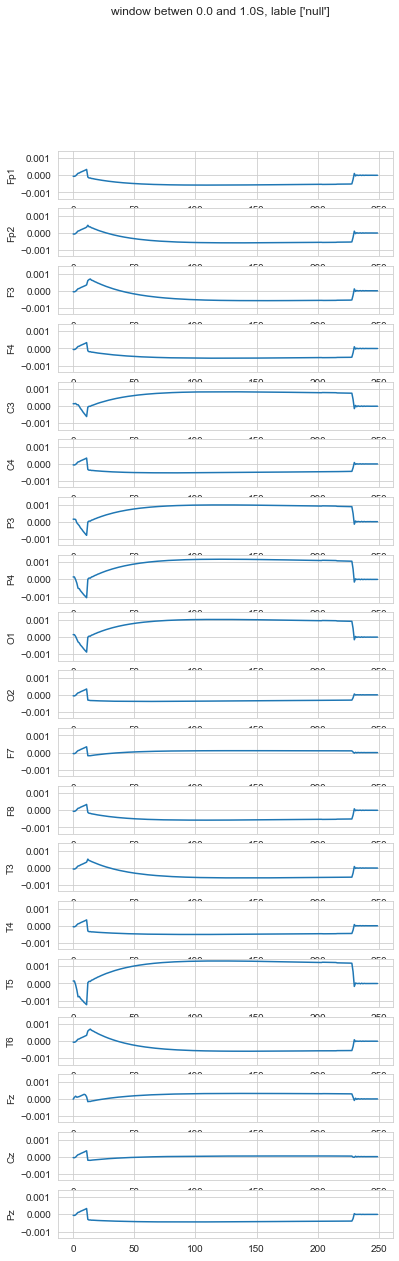

In [10]:
ploter.plot(test_dict[0]['window_0'])

#### 1.3) Using  the transform argument,  implement dynamic binarization,  where  the  binarized {0,1} pixels are sampled using the pixel intensity as the probability - DONE

## 2. VAE Implementation

#### 2.2.1 Setting up the model

In [11]:
import math 
import torch
from torch import nn, Tensor
from torch.nn.functional import softplus
from torch.distributions import Distribution


class ReparameterizedDiagonalGaussian(Distribution):
    """
    A distribution `N(y | mu, sigma I)` compatible with the reparameterization trick given `epsilon ~ N(0, 1)`.
    """
    def __init__(self, mu: Tensor, log_sigma:Tensor):
        assert mu.shape == log_sigma.shape, f"Tensors `mu` : {mu.shape} and ` log_sigma` : {log_sigma.shape} must be of the same shape"
        self.mu = mu
        self.sigma = log_sigma.exp()
        
    def sample_epsilon(self) -> Tensor:
        """`\eps ~ N(0, I)`"""
        return torch.empty_like(self.mu).normal_()
        
    def sample(self) -> Tensor:
        """sample `z ~ N(z | mu, sigma)` (without gradients)"""
        with torch.no_grad():
            return self.rsample()
        
    def rsample(self) -> Tensor:
        """sample `z ~ N(z | mu, sigma)` (with the reparameterization trick) """
        z=self.mu+self.sigma*self.sample_epsilon()
        return z

        
    def log_prob(self, z:Tensor) -> Tensor:
        """return the log probability: log `p(z)`"""
        normal_dist=torch.distributions.normal.Normal(self.mu,self.sigma)
        return normal_dist.log_prob(z) 

In [12]:
def cov(m, rowvar=False):
    if m.dim() > 2:
        raise ValueError('m has more than 2 dimensions')
    if m.dim() < 2:
        m = m.view(1, -1)
    if not rowvar and m.size(0) != 1:
        m = m.t()
    # m = m.type(torch.double)  # uncomment this line if desired
    fact = 1.0 / (m.size(1) - 1)
    m -= torch.mean(m, dim=1, keepdim=True)
    mt = m.t()  # if complex: mt = m.t().conj()
    return fact * m.matmul(mt).squeeze()

def multi_cov(m):
    cov_matrix = torch.empty(m.shape[0])
    for i in range(m.shape[0]):
        cov_matrix[i] = cov(m[i])
    return cov_matrix

##### Implement a VAE as atorch.nn.Module.

(a)  Implement a method.encode(...)that encodes a batch ofx.

(b)  Implement a method.decode(...)that decodes a batch ofz.

(c)  Implement a method.sample(...)that generates samples.

(d)  Implement a method.elbo(...)that computes the ELBO

In [13]:
class VariationalAutoencoder(nn.Module):
    """A Variational Autoencoder with
    * a Bernoulli observation model `p_\theta(x | z) = B(x | g_\theta(z))`
    * a Gaussian prior `p(z) = N(z | 0, I)`
    * a Gaussian posterior `q_\phi(z|x) = N(z | \mu(x), \sigma(x))`
    """
    
    def __init__(self, input_shape:torch.Size, latent_features:int) -> None:
        super(VariationalAutoencoder, self).__init__()
        
        self.input_shape = input_shape
        self.latent_features = latent_features
        self.observation_features = np.prod(input_shape)
        

        # Inference Network
        # Encode the observation `x` into the parameters of the posterior distribution
        # `q_\phi(z|x) = N(z | \mu(x), \sigma(x)), \mu(x),\log\sigma(x) = h_\phi(x)`
        self.encoder = nn.Sequential(
            nn.Linear(in_features=self.observation_features, out_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=128),
            nn.ReLU(),
            # A Gaussian is fully characterised by its mean \mu and variance \sigma**2
            nn.Linear(in_features=128, out_features=2*latent_features) # <- note the 2*latent_features
        )
        
        # Generative Model
        # Decode the latent sample `z` into the parameters of the observation model
        # `p_\theta(x | z) = \prod_i B(x_i | g_\theta(x))`
        self.decoder = nn.Sequential(
            nn.Linear(in_features=latent_features, out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=self.observation_features)
        )
        
        # define the parameters of the prior, chosen as p(z) = N(0, I)
        self.register_buffer('prior_params', torch.zeros(torch.Size([1, 2*latent_features])))

    def encode(self, x):
        return self.encoder(x)

    def decode(self, z):
        return self.decoder(z)

    def sample(self, x:Tensor, z = False):
        vi = VariationalInference(beta=1.0)
        loss, diagnostics, outputs = vi(vae, x)
        if z:
            pz = outputs['pz']   
            return pz.sample()
        px = outputs['px']
        return px.sample()

        
    def posterior(self, x:Tensor) -> Distribution:
        """return the distribution `q(x|x) = N(z | \mu(x), \sigma(x))`"""
        
        # compute the parameters of the posterior
        h_x = self.encode(x)
        mu, log_sigma =  h_x.chunk(2, dim=-1)
        
        # return a distribution `q(x|x) = N(z | \mu(x), \sigma(x))`
        return ReparameterizedDiagonalGaussian(mu, log_sigma)
    
    def prior(self, batch_size:int=1)-> Distribution:
        """return the distribution `p(z)`"""
        prior_params = self.prior_params.expand(batch_size, *self.prior_params.shape[-1:])
        mu, log_sigma = prior_params.chunk(2, dim=-1)
        
        # return the distribution `p(z)`
        return ReparameterizedDiagonalGaussian(mu, log_sigma)
    
    def observation_model(self, z:Tensor) -> Distribution:
        """return the distribution `p(x|z)`"""
        '''
        px_logits = self.decoder(z)
        px_logits = px_logits.view(-1, *self.input_shape) # reshape the output
        self.px_logits = px_logits
        dist = torch.distributions.bernoulli.Bernoulli(logits=px_logits)
        '''
        
        h_z = self.decoder(z)
        mu, log_sigma =  h_z.chunk(2, dim=-1)
        '''
        mean = torch.mean(x)
        cov_matrix = cov(x)
        '''
        dist = torch.distributions.normal.Normal(h_z, h_z)
        self.dist = dist
        self.h_z = h_z

        return dist

        

    def forward(self, x) -> Dict[str, Any]:
        """compute the posterior q(z|x) (encoder), sample z~q(z|x) and return the distribution p(x|z) (decoder)"""
        
        # flatten the input
        x = x.view(x.size(0), -1)
        
        # define the posterior q(z|x) / encode x into q(z|x)
        qz = self.posterior(x)
        
        # define the prior p(z)
        pz = self.prior(batch_size=x.size(0))
        
        # sample the posterior using the reparameterization trick: z ~ q(z | x)
        z = qz.rsample()
        
        # define the observation model p(x|z) = B(x | g(z))
        px = self.observation_model(z)
        
        return {'px': px, 'pz': pz, 'qz': qz, 'z': z}
    
    
    def sample_from_prior(self, batch_size:int=100):
        """sample z~p(z) and return p(x|z)"""
        
        # define the prior p(z)
        pz = self.prior(batch_size=batch_size)
        
        # sample the prior 
        z = pz.rsample()
        
        # define the observation model p(x|z) = B(x | g(z))
        px = self.observation_model(z)

        return {'px': px, 'pz': pz, 'z': z}

    def elbo(self,x:Tensor,beta=1):
        vi = VariationalInference(beta=1.0)
        _, diagnostics, _ = vi(vae, x)

        return diagnostics['elbo']
    
def reduce(x:Tensor) -> Tensor:
    """for each datapoint: sum over all dimensions"""
    return x.view(x.size(0), -1).sum(dim=1)

class VariationalInference(nn.Module):
    def __init__(self, beta:float=1.):
        super().__init__()
        self.beta = beta
        
    def forward(self, model:nn.Module, x:Tensor) -> Tuple[Tensor, Dict]:
        
        # forward pass through the model
        outputs = model(x)
        
        # unpack outputs
        px, pz, qz, z = [outputs[k] for k in ["px", "pz", "qz", "z"]]
        
        self.test = px.sample()
        
        # evaluate log probabilities
        log_px = reduce(px.log_prob(x))
        log_pz = reduce(pz.log_prob(z))
        log_qz = reduce(qz.log_prob(z))
        
        # compute the ELBO with and without the beta parameter: 
        # `L^\beta = E_q [ log p(x|z) - \beta * D_KL(q(z|x) | p(z))`
        # where `D_KL(q(z|x) | p(z)) = log q(z|x) - log p(z)`
        kl = log_qz - log_pz
        elbo =log_px-kl # <- your code here
        beta_elbo =log_px-self.beta * kl # <- your code here
        
        # loss
        loss = -beta_elbo.mean()
        
        # prepare the output
        with torch.no_grad():
            diagnostics = {'elbo': elbo, 'log_px':log_px, 'kl': kl}
            
        return loss, diagnostics, outputs

In [14]:
latent_features = 2
vae = VariationalAutoencoder(sample_x[0].shape, latent_features)
print(vae)

VariationalAutoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=4750, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=4, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=4750, bias=True)
  )
)


##### 2.(Report)Generate 64 samples from theuntrained modeland plot them on a 8×8 grid

In [15]:
untrained_samples = vae.sample(sample_x)

In [16]:
out_untrained_samples = [reshape(i) for i in untrained_samples]

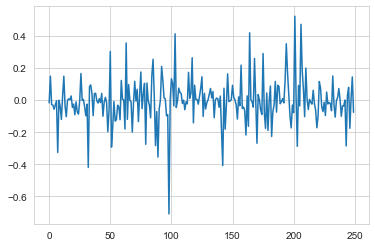

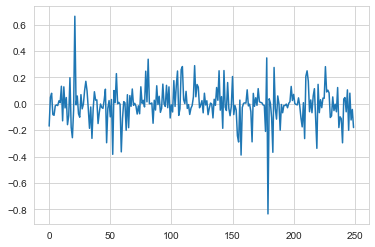

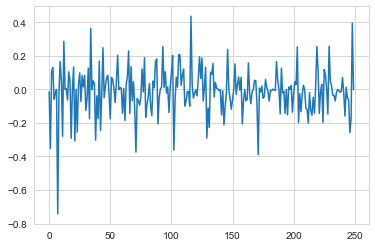

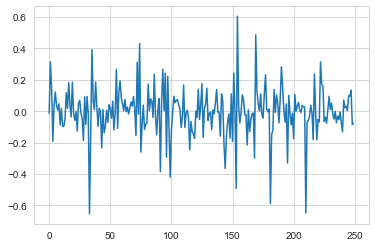

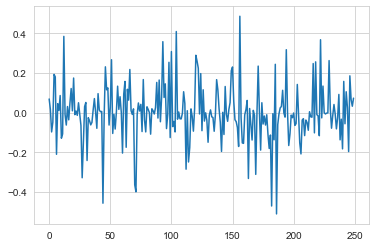

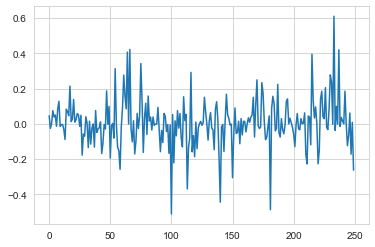

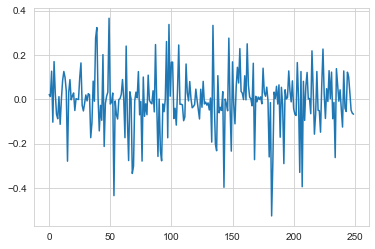

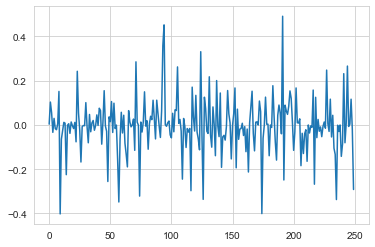

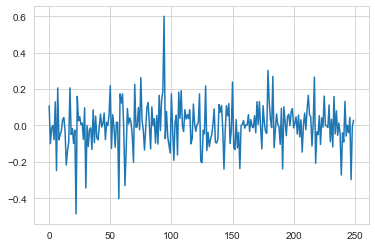

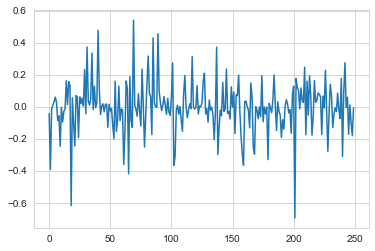

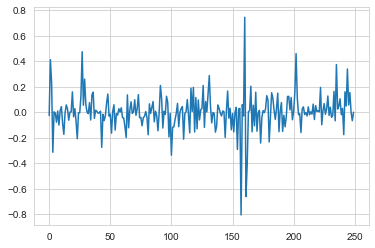

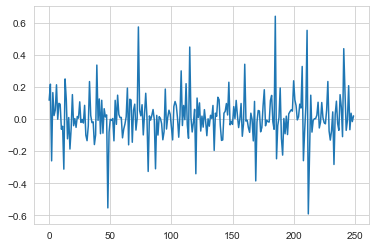

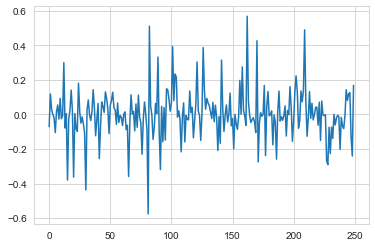

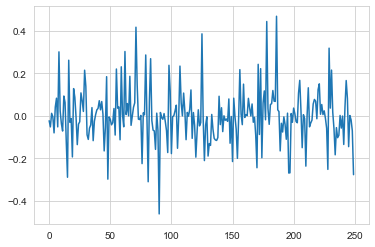

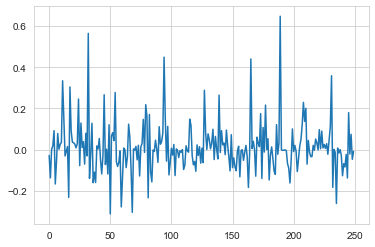

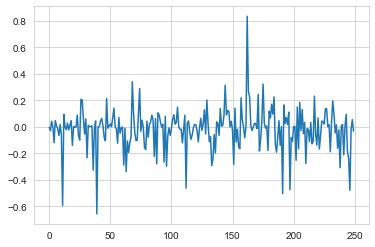

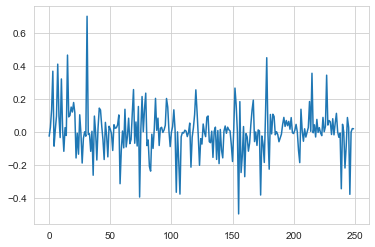

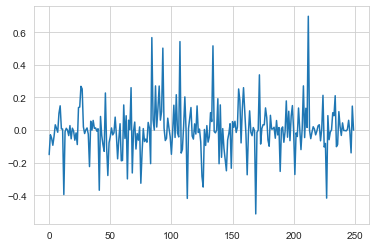

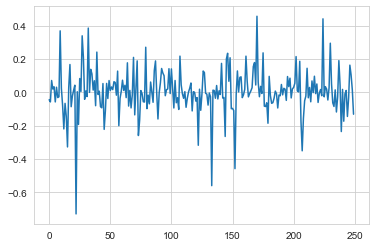

In [17]:
for channel in out_untrained_samples[0]:
    plt.figure()
    plt.plot(channel)
    plt.show()

##### (Report)Compute the ELBO of 64 samples from thetraining setusing theuntrained modeland report the number.

In [16]:
elbo = vae.elbo(sample_x)

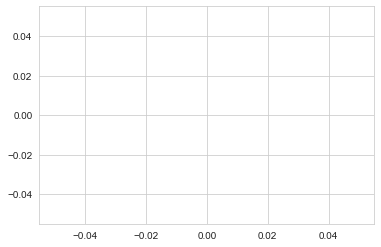

In [17]:
plt.plot(elbo.detach().numpy()) # Why does this not work?
plt.show()

#### 2.2.2  Setting up the training

In [18]:
from collections import defaultdict

# The Adam optimizer works really well with VAEs.
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)

# define dictionary to store the training curves
training_data = defaultdict(list)
validation_data = defaultdict(list)

epoch = 0

#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device="cpu"
print(f">> Using device: {device}")

# move the model to the device
vae = vae.to(device)

>> Using device: cpu


##### 1. Implement atrain(...)function that performs one epoch of training

In [22]:
def train(vae,annothlist,dataLoader, n_batches= 10):
    training_epoch_data = defaultdict(list)
    vae.train()
    
    # Go through each batch in the training dataset using the loader
    # Note that y is not necessarily known as it is here
    for batch in range(n_batches):
        windowlist,filelist=make_batch(annothlist,12)
        _,batch_X,_=dataLoader.loadBatch(edfDict=edfDict,filelist=filelist,windowlist=windowlist)
        
        x = torch.Tensor(np.array([x.flatten() for x in batch_X])).type(torch.float)
        
        # perform a forward pass through the model and compute the ELBO
        vi = VariationalInference(beta=1.0)
        loss, diagnostics, outputs = vi(vae, x)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # gather data for the current bach
        for k, v in diagnostics.items():
            training_epoch_data[k] += [v.mean().item()]

    return training_epoch_data
            

##### 2. Implement atest(...)function that evaluates the model on the test set.

In [23]:
def test(vae,annothlist,dataLoader,validation_data):
    # Evaluate on a single batch, do not propagate gradients
    with torch.no_grad():
        vae.eval()
        
        # Just load a single batch from the test loader
        windowlist,filelist=make_batch(annothlist,12)
        batch_Y,batch_X,_=dataLoader.loadBatch(edfDict=edfDict,filelist=filelist,windowlist=windowlist)
        
        x = torch.Tensor(np.array([x.flatten() for x in batch_X])).type(torch.float)
        y = torch.Tensor(np.array(batch_Y)).type(torch.int)
        
        # perform a forward pass through the model and compute the ELBO
        vi = VariationalInference(beta=1.0)
        loss, diagnostics, outputs = vi(vae, x)
        
        # gather data for the validation step
        for k, v in diagnostics.items():
            validation_data[k] += [v.mean().item()]
        return validation_data


##### 3. Train the model for some time (e.g.  100-200 epochs).  Remember to save thestatedictof themodel usingtorch.save!

In [24]:
# train
epoch = 0
num_epochs = 100
validation_data = defaultdict(list)

while epoch < num_epochs:
    if epoch%10 == 0:
      print("Epoch {0}/{1}".format(epoch,num_epochs))
    epoch+= 1
    
    # gather data for the full epoch
    training_epoch_data = train(vae,annothlist,DL)
    for k, v in training_epoch_data.items():
        training_data[k] += [np.mean(training_epoch_data[k])]

    validation_data = test(vae,annothlist,DL,validation_data)

Epoch 0/100
Extracting EDF parameters from C:\Users\blanc\OneDrive - Danmarks Tekniske Universitet\2.MScComputerScience\DeepLearning\artifact_dataset\artifact_dataset\01_tcp_ar\104\00010418\s009_2013_06_17\00010418_s009_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 392999  =      0.000 ...  1571.996 secs...
PHOTIC-REF
IBI
BURSTS
SUPPR
DigMontage is a superset of info. 324 in DigMontage will be ignored. The ignored channels are: {'PPO9', 'POO2', 'OI1', 'AF3', 'FTT9h', 'CCP3h', 'PO4h', 'P8', 'AF2', 'PPO8', 'TP9h', 'AFp8', 'FC5', 'I1h', 'AFp1h', 'PPO5h', 'FC2h', 'M2', 'PPO2h', 'FC5h', 'AF7', 'FFC6', 'TTP10', 'FCC6', 'FFC2h', 'TP8', 'I2h', 'F3h', 'FT10h', 'POO10', 'FCC1h', 'PPO9h', 'CCP6', 'AFF3', 'A1', 'AFp4h', 'CCP5h', 'TTP9h', 'F2h', 'FFC5', 'C1', 'CP2h', 'FT9h', 'PO5', 'F10', 'PO7', 'P9h', 'C5', 'C6', 'CCP4', 'T7h', 'T8', 'CP6h', 'POO3', 'AFF4', 'AF4', 'CCP4h', 'T7', 'CCP2', 'POO9', 'POO6', 'F1', 'CCP1', 'M1', 'TP7', 'AFp3h

['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\blanc\OneDrive - Danmarks Tekniske Universitet\2.MScComputerScience\DeepLearning\artifact_dataset\artifact_dataset\01_tcp_ar\093\00009340\s001_2012_10_04\00009340_s001_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 249249  =      0.000 ...   996.996 secs...
EMG-REF
PHOTIC-REF
IBI
BURSTS
SUPPR
DigMontage is a superset of info. 324 in DigMontage will be ignored. The ignored channels are: {'PPO9', 'POO2', 'OI1', 'AF3', 'FTT9h', 'CCP3h', 'PO4h', 'P8', 'AF2', 'PPO8', 'TP9h', 'AFp8', 'FC5', 'I1h', 'AFp1h', 'PPO5h', 'FC2h', 'M2', 'PPO2h', 'FC5h', 'AF7', 'FFC6', 'TTP10', 'FCC6', 'FFC2h', 'TP8', 'I2h', 'F3h', 'FT10h', 'POO10', 'FCC1h', 'PPO9h', 'CCP6', 'AFF3', 'A1', 'AFp4h

['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\blanc\OneDrive - Danmarks Tekniske Universitet\2.MScComputerScience\DeepLearning\artifact_dataset\artifact_dataset\01_tcp_ar\088\00008829\s001_2012_03_28\00008829_s001_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 358749  =      0.000 ...  1434.996 secs...
EMG-REF
PHOTIC-REF
IBI
BURSTS
SUPPR
DigMontage is a superset of info. 324 in DigMontage will be ignored. The ignored channels are: {'PPO9', 'POO2', 'OI1', 'AF3', 'FTT9h', 'CCP3h', 'PO4h', 'P8', 'AF2', 'PPO8', 'TP9h', 'AFp8', 'FC5', 'I1h', 'AFp1h', 'PPO5h', 'FC2h', 'M2', 'PPO2h', 'FC5h', 'AF7', 'FFC6', 'TTP10', 'FCC6', 'FFC2h', 'TP8', 'I2h', 'F3h', 'FT10h', 'POO10', 'FCC1h', 'PPO9h', 'CCP6', 'AFF3', 'A1', 'AFp4h

['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\blanc\OneDrive - Danmarks Tekniske Universitet\2.MScComputerScience\DeepLearning\artifact_dataset\artifact_dataset\01_tcp_ar\065\00006531\s002_2010_09_09\00006531_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 307999  =      0.000 ...  1231.996 secs...
EMG-REF
PHOTIC-REF
IBI
BURSTS
SUPPR
DigMontage is a superset of info. 324 in DigMontage will be ignored. The ignored channels are: {'PPO9', 'POO2', 'OI1', 'AF3', 'FTT9h', 'CCP3h', 'PO4h', 'P8', 'AF2', 'PPO8', 'TP9h', 'AFp8', 'FC5', 'I1h', 'AFp1h', 'PPO5h', 'FC2h', 'M2', 'PPO2h', 'FC5h', 'AF7', 'FFC6', 'TTP10', 'FCC6', 'FFC2h', 'TP8', 'I2h', 'F3h', 'FT10h', 'POO10', 'FCC1h', 'PPO9h', 'CCP6', 'AFF3', 'A1', 'AFp4h

['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\blanc\OneDrive - Danmarks Tekniske Universitet\2.MScComputerScience\DeepLearning\artifact_dataset\artifact_dataset\01_tcp_ar\100\00010024\s001_2013_02_18\00010024_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 374499  =      0.000 ...  1497.996 secs...
EMG-REF
PHOTIC-REF
IBI
BURSTS
SUPPR
DigMontage is a superset of info. 324 in DigMontage will be ignored. The ignored channels are: {'PPO9', 'POO2', 'OI1', 'AF3', 'FTT9h', 'CCP3h', 'PO4h', 'P8', 'AF2', 'PPO8', 'TP9h', 'AFp8', 'FC5', 'I1h', 'AFp1h', 'PPO5h', 'FC2h', 'M2', 'PPO2h', 'FC5h', 'AF7', 'FFC6', 'TTP10', 'FCC6', 'FFC2h', 'TP8', 'I2h', 'F3h', 'FT10h', 'POO10', 'FCC1h', 'PPO9h', 'CCP6', 'AFF3', 'A1', 'AFp4h

['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\blanc\OneDrive - Danmarks Tekniske Universitet\2.MScComputerScience\DeepLearning\artifact_dataset\artifact_dataset\01_tcp_ar\081\00008181\s003_2011_10_13\00008181_s003_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 153855  =      0.000 ...   600.996 secs...
EMG-REF
IBI
BURSTS
SUPPR
DigMontage is a superset of info. 324 in DigMontage will be ignored. The ignored channels are: {'PPO9', 'POO2', 'OI1', 'AF3', 'FTT9h', 'CCP3h', 'PO4h', 'P8', 'AF2', 'PPO8', 'TP9h', 'AFp8', 'FC5', 'I1h', 'AFp1h', 'PPO5h', 'FC2h', 'M2', 'PPO2h', 'FC5h', 'AF7', 'FFC6', 'TTP10', 'FCC6', 'FFC2h', 'TP8', 'I2h', 'F3h', 'FT10h', 'POO10', 'FCC1h', 'PPO9h', 'CCP6', 'AFF3', 'A1', 'AFp4h', 'CCP5h',

['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\blanc\OneDrive - Danmarks Tekniske Universitet\2.MScComputerScience\DeepLearning\artifact_dataset\artifact_dataset\01_tcp_ar\076\00007647\s001_2011_02_07\00007647_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 301999  =      0.000 ...  1207.996 secs...
EMG-REF
PHOTIC-REF
IBI
BURSTS
SUPPR
DigMontage is a superset of info. 324 in DigMontage will be ignored. The ignored channels are: {'PPO9', 'POO2', 'OI1', 'AF3', 'FTT9h', 'CCP3h', 'PO4h', 'P8', 'AF2', 'PPO8', 'TP9h', 'AFp8', 'FC5', 'I1h', 'AFp1h', 'PPO5h', 'FC2h', 'M2', 'PPO2h', 'FC5h', 'AF7', 'FFC6', 'TTP10', 'FCC6', 'FFC2h', 'TP8', 'I2h', 'F3h', 'FT10h', 'POO10', 'FCC1h', 'PPO9h', 'CCP6', 'AFF3', 'A1', 'AFp4h

['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\blanc\OneDrive - Danmarks Tekniske Universitet\2.MScComputerScience\DeepLearning\artifact_dataset\artifact_dataset\01_tcp_ar\034\00003465\s004_2010_11_08\00003465_s004_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 294999  =      0.000 ...  1179.996 secs...
EMG-REF
PHOTIC-REF
IBI
BURSTS
SUPPR
DigMontage is a superset of info. 324 in DigMontage will be ignored. The ignored channels are: {'PPO9', 'POO2', 'OI1', 'AF3', 'FTT9h', 'CCP3h', 'PO4h', 'P8', 'AF2', 'PPO8', 'TP9h', 'AFp8', 'FC5', 'I1h', 'AFp1h', 'PPO5h', 'FC2h', 'M2', 'PPO2h', 'FC5h', 'AF7', 'FFC6', 'TTP10', 'FCC6', 'FFC2h', 'TP8', 'I2h', 'F3h', 'FT10h', 'POO10', 'FCC1h', 'PPO9h', 'CCP6', 'AFF3', 'A1', 'AFp4h

['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\blanc\OneDrive - Danmarks Tekniske Universitet\2.MScComputerScience\DeepLearning\artifact_dataset\artifact_dataset\01_tcp_ar\093\00009320\s001_2012_08_01\00009320_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 302999  =      0.000 ...  1211.996 secs...
EMG-REF
PHOTIC-REF
IBI
BURSTS
SUPPR
DigMontage is a superset of info. 324 in DigMontage will be ignored. The ignored channels are: {'PPO9', 'POO2', 'OI1', 'AF3', 'FTT9h', 'CCP3h', 'PO4h', 'P8', 'AF2', 'PPO8', 'TP9h', 'AFp8', 'FC5', 'I1h', 'AFp1h', 'PPO5h', 'FC2h', 'M2', 'PPO2h', 'FC5h', 'AF7', 'FFC6', 'TTP10', 'FCC6', 'FFC2h', 'TP8', 'I2h', 'F3h', 'FT10h', 'POO10', 'FCC1h', 'PPO9h', 'CCP6', 'AFF3', 'A1', 'AFp4h

['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\blanc\OneDrive - Danmarks Tekniske Universitet\2.MScComputerScience\DeepLearning\artifact_dataset\artifact_dataset\01_tcp_ar\019\00001981\s007_2015_03_30\00001981_s007_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 153855  =      0.000 ...   600.996 secs...
IBI
BURSTS
SUPPR
DigMontage is a superset of info. 324 in DigMontage will be ignored. The ignored channels are: {'PPO9', 'POO2', 'OI1', 'AF3', 'FTT9h', 'CCP3h', 'PO4h', 'P8', 'AF2', 'PPO8', 'TP9h', 'AFp8', 'FC5', 'I1h', 'AFp1h', 'PPO5h', 'FC2h', 'M2', 'PPO2h', 'FC5h', 'AF7', 'FFC6', 'TTP10', 'FCC6', 'FFC2h', 'TP8', 'I2h', 'F3h', 'FT10h', 'POO10', 'FCC1h', 'PPO9h', 'CCP6', 'AFF3', 'A1', 'AFp4h', 'CCP5h', 'TTP9h'

['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\blanc\OneDrive - Danmarks Tekniske Universitet\2.MScComputerScience\DeepLearning\artifact_dataset\artifact_dataset\01_tcp_ar\062\00006224\s002_2010_01_06\00006224_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 297749  =      0.000 ...  1190.996 secs...
EMG-REF
PHOTIC-REF
IBI
BURSTS
SUPPR
DigMontage is a superset of info. 324 in DigMontage will be ignored. The ignored channels are: {'PPO9', 'POO2', 'OI1', 'AF3', 'FTT9h', 'CCP3h', 'PO4h', 'P8', 'AF2', 'PPO8', 'TP9h', 'AFp8', 'FC5', 'I1h', 'AFp1h', 'PPO5h', 'FC2h', 'M2', 'PPO2h', 'FC5h', 'AF7', 'FFC6', 'TTP10', 'FCC6', 'FFC2h', 'TP8', 'I2h', 'F3h', 'FT10h', 'POO10', 'FCC1h', 'PPO9h', 'CCP6', 'AFF3', 'A1', 'AFp4h

['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\blanc\OneDrive - Danmarks Tekniske Universitet\2.MScComputerScience\DeepLearning\artifact_dataset\artifact_dataset\01_tcp_ar\065\00006535\s006_2012_07_19\00006535_s006_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 611583  =      0.000 ...  2388.996 secs...
EMG-REF
IBI
BURSTS
SUPPR
DigMontage is a superset of info. 324 in DigMontage will be ignored. The ignored channels are: {'PPO9', 'POO2', 'OI1', 'AF3', 'FTT9h', 'CCP3h', 'PO4h', 'P8', 'AF2', 'PPO8', 'TP9h', 'AFp8', 'FC5', 'I1h', 'AFp1h', 'PPO5h', 'FC2h', 'M2', 'PPO2h', 'FC5h', 'AF7', 'FFC6', 'TTP10', 'FCC6', 'FFC2h', 'TP8', 'I2h', 'F3h', 'FT10h', 'POO10', 'FCC1h', 'PPO9h', 'CCP6', 'AFF3', 'A1', 'AFp4h', 'CCP5h',

ValueError: No channels match the selection.

In [ ]:
# save model
path = "model.pt"
torch.save(vae.state_dict(), path)

[**SKIP the above if the training is finished. Just load the moodel.**]

In [139]:
# train model
vae.load_state_dict(torch.load(path))

<All keys matched successfully>

##### 4.(Report)Generate 64 samples from thetrained modeland plot them on a 8×8 grid.

In [141]:
trained_samples = vae.sample(sample_x)

In [142]:
out_trained_samples = [reshape(i) for i in trained_samples]

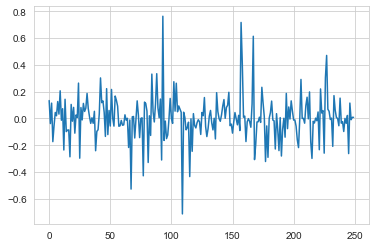

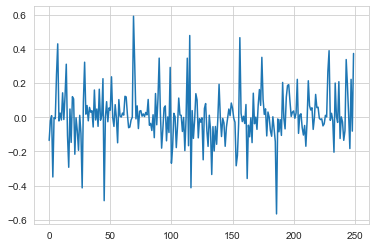

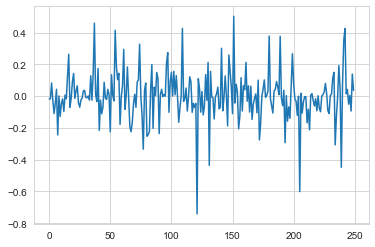

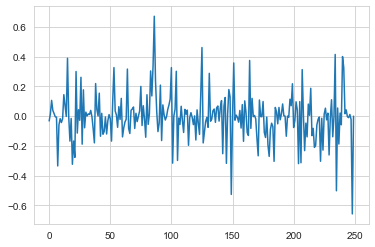

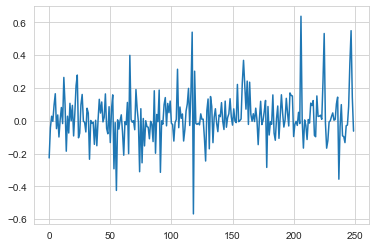

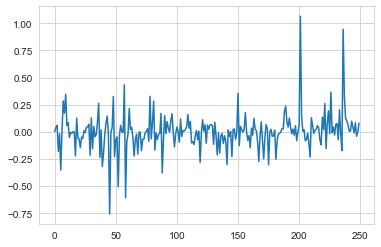

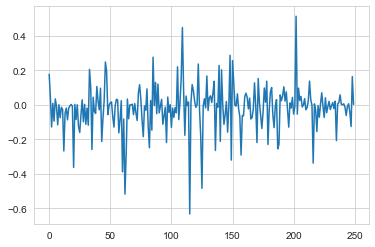

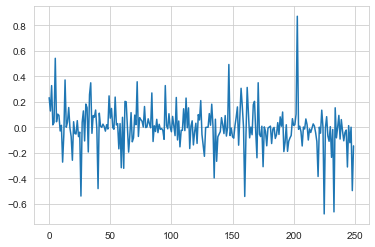

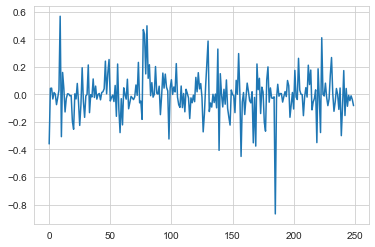

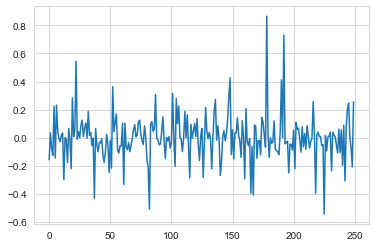

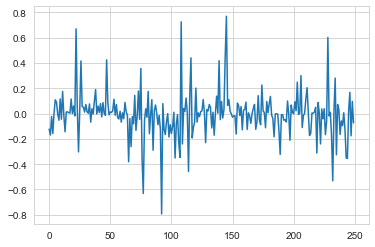

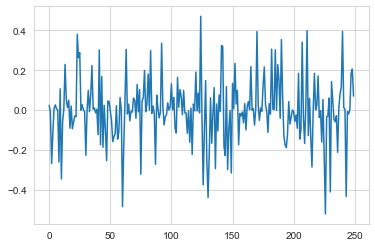

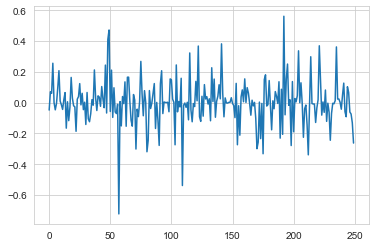

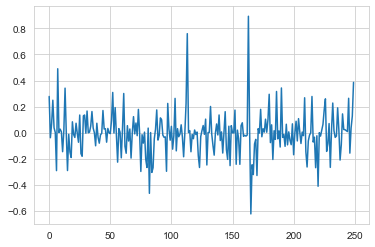

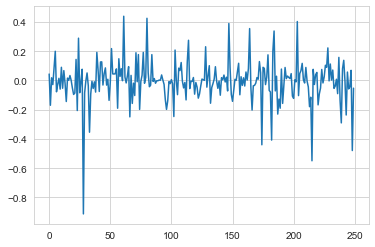

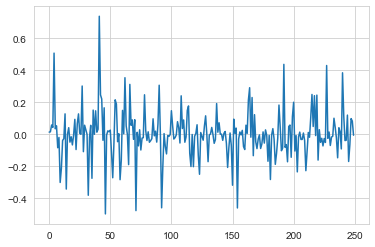

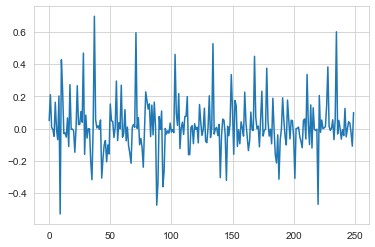

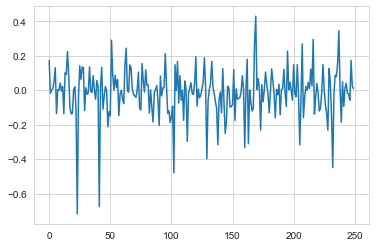

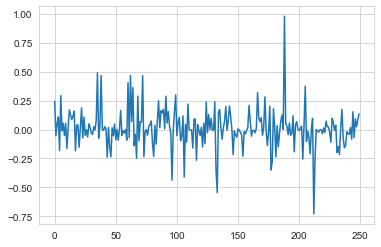

In [143]:
for channel in out_trained_samples[0]:
    plt.figure()
    plt.plot(channel)
    plt.show()

##### 5.(Report)Evaluate thetrained modelon the test set and report the number.

In [145]:
# Reproduce the figure from the begining of the notebook, plot the training curves and show latent samples
with torch.no_grad():
  windowlist,filelist=make_batch(annothlist,12)
  _,batch_X,_=DL.loadBatch(edfDict=edfDict,filelist=filelist,windowlist=windowlist)
  loss, diagnostics, outputs = vi(sample_x)
  make_vae_plots(vae, x, y, outputs, training_data, validation_data)

Extracting EDF parameters from C:\Users\blanc\OneDrive - Danmarks Tekniske Universitet\2.MScComputerScience\DeepLearning\artifact_dataset\artifact_dataset\01_tcp_ar\068\00006880\s001_2010_09_14\00006880_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 303749  =      0.000 ...  1214.996 secs...
EMG-REF
PHOTIC-REF
IBI
BURSTS
SUPPR
DigMontage is a superset of info. 324 in DigMontage will be ignored. The ignored channels are: {'CPP6h', 'P2h', 'A1', 'FC2', 'PPO7h', 'FC6', 'AF2h', 'CPz', 'AFp8', 'POO10h', 'T9', 'CP4', 'POO1', 'PO3', 'POO7', 'AF6', 'AFp9h', 'FFC6h', 'AFF7', 'C6h', 'TTP10h', 'FCC2h', 'PO5', 'AFF7h', 'F2', 'FT10h', 'PPO3', 'CCP5', 'FFT9h', 'POO8', 'O1h', 'I1h', 'P4h', 'P2', 'FTT9h', 'PPO10', 'FC1h', 'FTT7', 'AFF10h', 'TPP8h', 'POO5h', 'AFp4', 'CCP6', 'TTP7h', 'POO9h', 'T7', 'C5', 'AFF4', 'TPP7', 'FT8h', 'AFF1h', 'F9', 'CPP1h', 'FTT10', 'CP5h', 'PPO5', 'AFp2h', 'FFT10h', 'CP2h', 'F3h', 'FC2h', 'POO3h', 'FT9', 'CCP2

['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\blanc\OneDrive - Danmarks Tekniske Universitet\2.MScComputerScience\DeepLearning\artifact_dataset\artifact_dataset\01_tcp_ar\080\00008044\s001_2011_03_23\00008044_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 359249  =      0.000 ...  1436.996 secs...
EMG-REF
PHOTIC-REF
IBI
BURSTS
SUPPR
DigMontage is a superset of info. 324 in DigMontage will be ignored. The ignored channels are: {'CPP6h', 'P2h', 'A1', 'FC2', 'PPO7h', 'FC6', 'AF2h', 'CPz', 'AFp8', 'POO10h', 'T9', 'CP4', 'POO1', 'PO3', 'POO7', 'AF6', 'AFp9h', 'FFC6h', 'AFF7', 'C6h', 'TTP10h', 'FCC2h', 'PO5', 'AFF7h', 'F2', 'FT10h', 'PPO3', 'CCP5', 'FFT9h', 'POO8', 'O1h', 'I1h', 'P4h', 'P2', 'FTT9h', 'PPO10', 

['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\blanc\OneDrive - Danmarks Tekniske Universitet\2.MScComputerScience\DeepLearning\artifact_dataset\artifact_dataset\01_tcp_ar\088\00008829\s001_2012_03_28\00008829_s001_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 358749  =      0.000 ...  1434.996 secs...
EMG-REF
PHOTIC-REF
IBI
BURSTS
SUPPR
DigMontage is a superset of info. 324 in DigMontage will be ignored. The ignored channels are: {'CPP6h', 'P2h', 'A1', 'FC2', 'PPO7h', 'FC6', 'AF2h', 'CPz', 'AFp8', 'POO10h', 'T9', 'CP4', 'POO1', 'PO3', 'POO7', 'AF6', 'AFp9h', 'FFC6h', 'AFF7', 'C6h', 'TTP10h', 'FCC2h', 'PO5', 'AFF7h', 'F2', 'FT10h', 'PPO3', 'CCP5', 'FFT9h', 'POO8', 'O1h', 'I1h', 'P4h', 'P2', 'FTT9h', 'PPO10', 

ValueError: No channels match the selection.

### 2.3  Semi-Supervised VAE (M1)

We have now trained a VAE on the full unlabeled dataset.  We will now implement the M1 modelfromSemi-Supervised Learning with Deep Generative Models. This amounts to simply traininga classifier on top of the representations learned by our VAE.

In [148]:
from sklearn import svm

def discriminativeTraining(vae,dataLoader,n_batches,annothlist):
    z = np.array([])
    for batch in range(n_batches):
        windowlist,filelist=make_batch(annothlist,12)
        batch_Y,batch_X,_=dataLoader.loadBatch(edfDict=edfDict,filelist=filelist,windowlist=windowlist)

        x = torch.Tensor(np.array([x.flatten() for x in batch_X])).type(torch.float)
        y = np.array([int(y) for y in batch_Y])
        
        for xi in x:
            zi = vae.sample(xi,z=True)
            np.append(x,zi)
    
    clf = svm.SVC()
    clf.fit(z, y) 
    return clf

In [155]:
# train
num_epochs = 5
vae = VariationalAutoencoder(sample_x[0].shape, latent_features)

SVC = discriminativeTraining(vae,DL,5,annothlist)

Extracting EDF parameters from C:\Users\blanc\OneDrive - Danmarks Tekniske Universitet\2.MScComputerScience\DeepLearning\artifact_dataset\artifact_dataset\01_tcp_ar\101\00010158\s004_2013_01_15\00010158_s004_t001.edf...
EDF file detected


OSError: [Errno 22] Invalid argument

In [152]:
z = vae.sample(sample_x,z=True)
SVV.predict(z,sample_y)

NameError: name 'SVV' is not defined

In [ ]:
def generativeTraining(vae,train_loader):
   vae.train()
   epoch = 0
   num_epochs = 10

   z = torch.zeros(num_epochs)
   loss = torch.zeros(num_epochs)

   while epoch < num_epochs:
      epoch+= 1
      x_batch,_ = getRandomMiniBatch(train_loader)
      for i in range(len(x_batch)):
            # sample zi from posterior q(zi|xi)
            loss[i],_,outputs = vae.variatonal_inference(x_batch[i])
            z[i] = outputs['z']
      # variational bound
      J = sum(loss)
      optimizer.zero_grad()
      J.backward()
      optimizer.step()
   return J
    #g_theta,g_phi = (dJ/dtheta, dJ/dphi)
    #theta,phi += T(g_theta,g_phi)

def discriminativeTraining(train_loader):
  _,y_batch = getRandomMiniBatch(train_loader)
  for xi,yi in zip(x,y):
    # sample zi from posterior q(zi|xi)
    # z[i] = q(zi|xi)
    trainClassifier(z,y)



In [34]:
def generative_training(num_epochs,vae,train_loader):

  epoch = 0
  validation_data = defaultdict(list)

  while epoch < num_epochs:
      if epoch%10 == 0:
        print("Epoch {0}/{1}".format(epoch,num_epochs))
      epoch+= 1
      
      training_epoch_data = defaultdict(list)
      vae.train()
      zt,yt,xt = [],[],[]
      
      # Go through each batch in the training dataset using the loader
      # Note that y is not necessarily known as it is here
      for x, y in train_loader:
          x = x.to(device)
          
          # perform a forward pass through the model and compute the ELBO
          loss, diagnostics, outputs = vae.variatonal_inference(x)
          zt += outputs['z']
          yt += y
          xt += x
          
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
          
          # gather data for the current bach
          for k, v in diagnostics.items():
              training_epoch_data[k] += [v.mean().item()]

      for k, v in training_epoch_data.items():
        training_data[k] += [np.mean(training_epoch_data[k])]

  with torch.no_grad():
    z = [i.numpy() for i in zt]
    y = [i.numpy() for i in yt]
    x = [i.numpy() for i in xt]

  return z,y,x